In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from umap import UMAP

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/cluster/Sex_ukb_OLS_FColl-SRh_right_with-residualization.csv"
label = "Sex"
covariates = ["Age", "BrainVolumeFreeSurfer_mm3"]
max_iter = 2000
cv = 3

In [3]:
participants = pd.read_csv(participants_file, index_col=0)
participants.head()

,Sex,Age,BrainVolumeFreeSurfer_mm3,Ageattendedimaging,ImagingName,isBigBrain,isOld
participant_id,,,,,,,
sub-3411469,1,65.0,1136465.0,65.0,Cheadle,NaN,NaN
sub-2290292,0,69.0,1079118.0,69.0,Newcastle,NaN,NaN
sub-3842391,0,70.0,1124077.0,70.0,Cheadle,NaN,NaN
sub-2758537,1,49.0,1246758.0,49.0,Newcastle,NaN,0.0
sub-4334619,1,70.0,1410387.0,70.0,Cheadle,1.0,NaN


In [4]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [5]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [6]:
participants = participants[[label] + covariates].dropna()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'BrainVolumeFreeSurfer_mm3'}>, <Axes: >]],
      dtype=object)

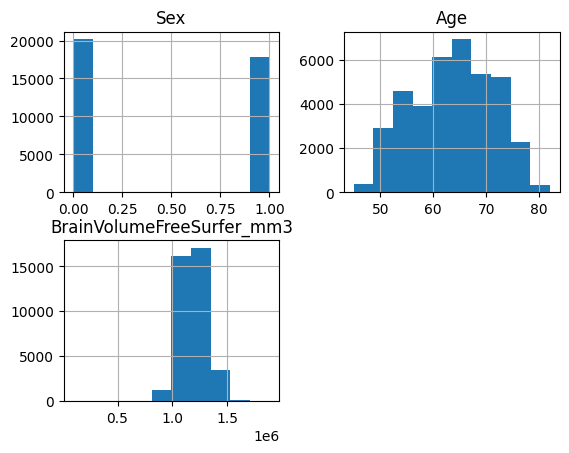

In [7]:
participants.hist()

In [8]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [9]:
model_paths = get_model_paths(path_champollion)

In [10]:
model_paths = [m for m in model_paths if "FColl-SRh_right" in m ]

In [11]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [14]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)

    # Residualizes
    # phenotypes_cols = embeddings.columns
    # merged = participants[covariates].merge(embeddings, left_index=True, right_index=True)
    # resid_df = merged[covariates].copy()
    # resid_df.loc[:, phenotypes_cols] = 0.0
    # for dim_i in phenotypes_cols:
    #     X = merged[covariates]
    #     X = sm.add_constant(X)
    #     y = merged[dim_i]
    #     model = sm.OLS(y, X).fit()
    #     residuals = model.resid
    #     resid_df.loc[:, dim_i] = residuals
    #     # ypred = model.predict(X)
    #     # residuals2 = y - ypred

    #     # print(f"diff residuals = {((residuals2-residuals)**2).sum()}")

    # Merge
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    ypred = results.predict(df2)
    f_value = results.fvalue
    p_value = results.f_pvalue

    # df = Y.copy()
    # df["predicted"] = df2.dot(results.params)
    # # predicted = pd.DataFrame(model.predict(results.params), columns=["predicted"])
    # # predicted = sm.add_constant(predicted)
    # # predicted.index = Y.index
    # # print(predicted[:5])
    # results = sm.OLS(df[label], 2*df["predicted"]).fit()

    # print(results.summary())
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path), merged, ypred

In [15]:
results = []
for model_path in model_paths:
    result, merged, ypred = compute(model_path)
    results.append(result)

Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
38.31420378619154


In [16]:
merged0 = merged.copy()
merged0.insert(0, "ypred", ypred)

<Axes: xlabel='ypred', ylabel='Count'>

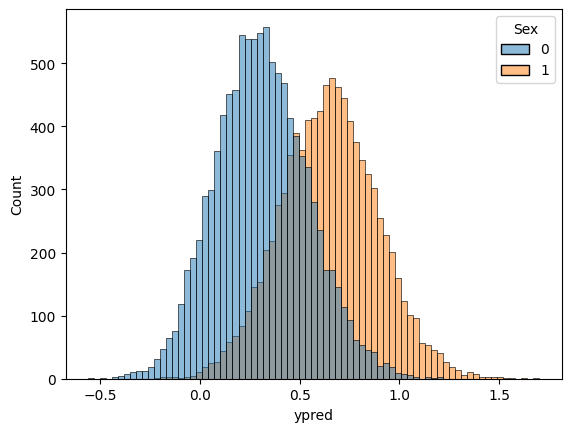

In [17]:
sns.histplot(merged0, x="ypred", hue="Sex")

In [18]:
merged.insert(0, "ypred", ypred)


In [19]:
merged["ypred"] = [0 if x < 0.35 else 1 if x > 0.55 else np.nan for x in merged["ypred"]]

In [20]:
merged

,ypred,Sex,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-3411469,1.0,1,83.346080,-74.536190,53.388603,13.190001,45.892395,20.905140,33.862790,-81.084020,...,-3.503992,-1.661455,78.083730,92.333280,73.631874,-33.088330,-3.850761,-23.204315,3.667275,29.368801
sub-2290292,0.0,0,66.407380,41.085567,5.292599,-18.962975,3.961737,-31.124120,-0.886595,-119.140680,...,33.478573,6.041600,13.425656,-17.598269,6.755402,-4.875114,20.157350,-32.281425,37.266155,14.782287
sub-4334619,NaN,1,3.121562,18.890688,-43.297916,-26.588724,-42.251804,23.928010,24.845520,-210.162960,...,-15.676660,25.229755,-38.478477,-55.105870,-15.509622,60.123466,-7.375762,29.218490,-14.324673,23.318594
sub-1188492,0.0,0,-22.156948,28.412280,22.274609,29.915869,34.469345,-3.566134,6.862311,-60.477480,...,12.289491,-0.993686,-32.777725,37.665623,48.240765,-39.235355,-10.213396,-62.504753,-1.498042,0.126285
sub-3798925,0.0,0,64.246994,-64.178280,33.022060,56.126590,-25.959856,11.287906,19.162228,-175.191740,...,5.346510,77.311424,33.799316,8.377530,-12.345369,-28.635046,-6.202348,17.007805,52.862106,21.069220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5405288,NaN,1,-21.056698,-42.610115,50.809315,69.997180,-1.539601,4.862592,20.668540,-105.511986,...,-14.471737,28.789394,-0.962491,18.719107,70.093330,17.040266,-12.442283,-4.982587,-8.139367,51.983980
sub-5206663,NaN,0,27.551527,-65.751640,36.876945,-1.139679,-48.225920,32.438873,32.482920,-162.578380,...,37.683080,18.012420,-31.695719,56.002415,13.758921,42.217310,6.868992,27.752136,37.355550,-3.959748
sub-1895291,0.0,0,0.544671,46.964657,-38.790367,7.671892,47.889160,-1.462372,-43.141730,-151.974620,...,44.428400,40.321760,-52.824574,11.985073,11.912171,10.155075,0.372957,-23.939780,21.934233,-32.302420
sub-2621329,1.0,1,-55.239407,-44.332897,48.468900,-44.474980,-36.908844,-24.372270,11.570223,-122.217766,...,41.981760,9.705443,52.212822,13.827290,2.790567,20.292295,-4.097774,-6.109909,27.652483,35.718456


In [21]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [22]:
merged.iloc[:,2:]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-3411469,83.346080,-74.536190,53.388603,13.190001,45.892395,20.905140,33.862790,-81.084020,-18.881624,36.409546,...,-3.503992,-1.661455,78.083730,92.333280,73.631874,-33.088330,-3.850761,-23.204315,3.667275,29.368801
sub-2290292,66.407380,41.085567,5.292599,-18.962975,3.961737,-31.124120,-0.886595,-119.140680,-27.070904,29.915594,...,33.478573,6.041600,13.425656,-17.598269,6.755402,-4.875114,20.157350,-32.281425,37.266155,14.782287
sub-4334619,3.121562,18.890688,-43.297916,-26.588724,-42.251804,23.928010,24.845520,-210.162960,1.993989,-31.084396,...,-15.676660,25.229755,-38.478477,-55.105870,-15.509622,60.123466,-7.375762,29.218490,-14.324673,23.318594
sub-1188492,-22.156948,28.412280,22.274609,29.915869,34.469345,-3.566134,6.862311,-60.477480,22.534002,-2.004743,...,12.289491,-0.993686,-32.777725,37.665623,48.240765,-39.235355,-10.213396,-62.504753,-1.498042,0.126285
sub-3798925,64.246994,-64.178280,33.022060,56.126590,-25.959856,11.287906,19.162228,-175.191740,-5.998609,24.942915,...,5.346510,77.311424,33.799316,8.377530,-12.345369,-28.635046,-6.202348,17.007805,52.862106,21.069220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5405288,-21.056698,-42.610115,50.809315,69.997180,-1.539601,4.862592,20.668540,-105.511986,-12.529864,14.746360,...,-14.471737,28.789394,-0.962491,18.719107,70.093330,17.040266,-12.442283,-4.982587,-8.139367,51.983980
sub-5206663,27.551527,-65.751640,36.876945,-1.139679,-48.225920,32.438873,32.482920,-162.578380,-90.447580,-35.250313,...,37.683080,18.012420,-31.695719,56.002415,13.758921,42.217310,6.868992,27.752136,37.355550,-3.959748
sub-1895291,0.544671,46.964657,-38.790367,7.671892,47.889160,-1.462372,-43.141730,-151.974620,-47.277325,-21.642790,...,44.428400,40.321760,-52.824574,11.985073,11.912171,10.155075,0.372957,-23.939780,21.934233,-32.302420
sub-2621329,-55.239407,-44.332897,48.468900,-44.474980,-36.908844,-24.372270,11.570223,-122.217766,-9.014587,46.295486,...,41.981760,9.705443,52.212822,13.827290,2.790567,20.292295,-4.097774,-6.109909,27.652483,35.718456


In [23]:
visual, _ = compute_umap(merged.iloc[:,2:])

/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


<Axes: xlabel='vis0', ylabel='vis1'>

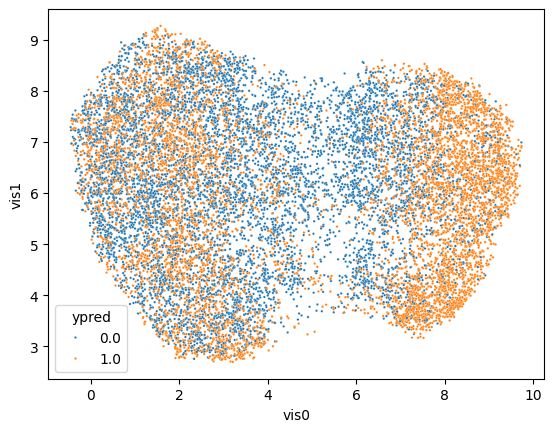

In [24]:
visual_df = merged[[label, "ypred"]].copy()
visual_df[["vis0", "vis1"]] = visual
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue="ypred", s=3)

<Axes: xlabel='vis0', ylabel='vis1'>

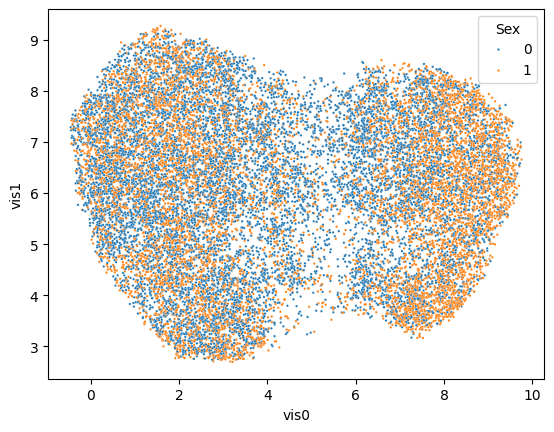

In [25]:
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue=label, s=3)

In [26]:
visual_df

,Sex,ypred,vis0,vis1
sub-3411469,1,1.0,6.745450,4.141829
sub-2290292,0,0.0,2.991748,3.623530
sub-4334619,1,NaN,1.232894,7.345156
sub-1188492,0,0.0,6.167345,7.029464
sub-3798925,0,0.0,1.252981,6.273694
...,...,...,...,...
sub-5405288,1,NaN,7.406559,6.165370
sub-5206663,0,NaN,1.644668,8.682719
sub-1895291,0,0.0,2.130881,7.906273
sub-2621329,1,1.0,8.900448,7.709842


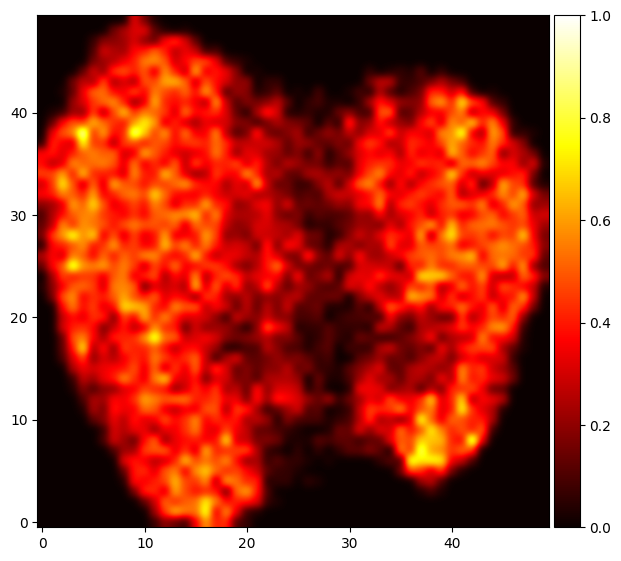

In [27]:
fig, ax = plt.subplots(figsize=[7,10], ncols=1)


# Plots heatmap
Z, xedges, yedges = np.histogram2d(visual_df["vis0"], visual_df["vis1"], bins=50, density=True)
Z = Z/np.unique(Z)[-1]
im = ax.imshow(Z.T,
          origin='lower',
          cmap='hot', 
          interpolation='gaussian'
          )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

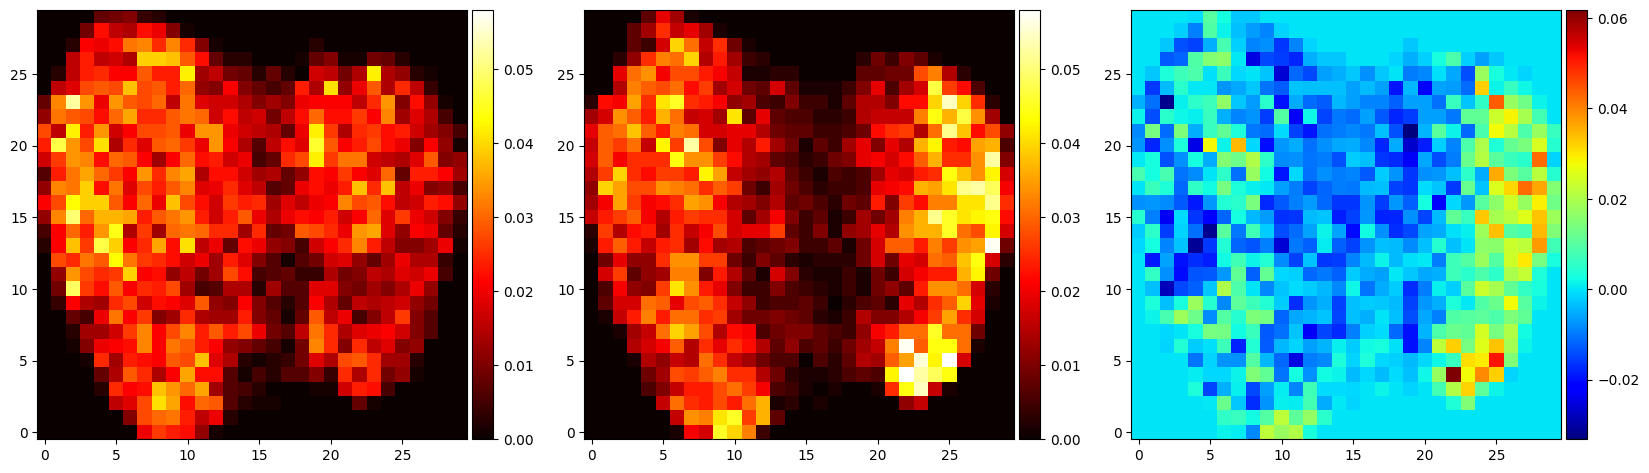

In [28]:
fig, ax = plt.subplots(figsize=[20,10], ncols=3)


# Plots heatmap of females
females = visual_df[visual_df[label]==0]
Z, xedges, yedges = np.histogram2d(females["vis0"], females["vis1"], bins=30, density=True)
# Zf = Z/np.unique(Z)[-1]
Zf = Z
im = ax[0].imshow(Zf.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.058
          )
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of males
males = visual_df[visual_df[label]==1]
Z, xedges, yedges = np.histogram2d(males["vis0"], males["vis1"], bins=30, density=True)
# Zm = Z/np.unique(Z)[-1]
Zm = Z
im = ax[1].imshow(Zm.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.058
          )
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of differenc
Z = Zm-Zf
im = ax[2].imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none'
          )

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

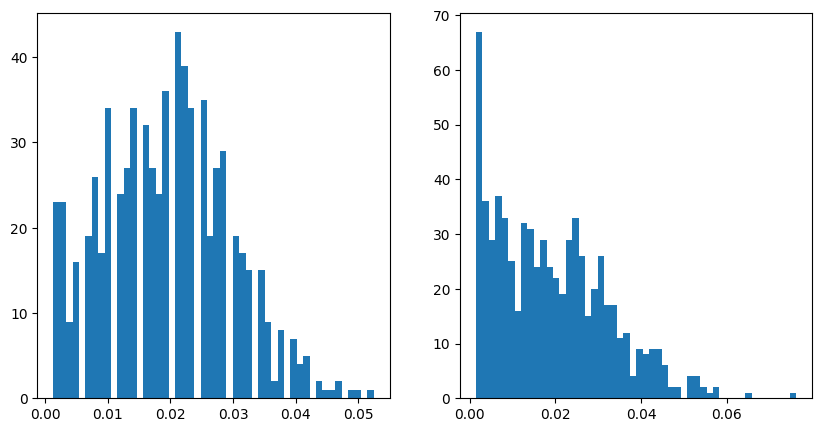

In [29]:
fig, ax = plt.subplots(figsize=[10,5], ncols=2)
p = ax[0].hist(Zf[Zf!=0].flatten(), bins=50)
p = ax[1].hist(Zm[Zm!=0].flatten(), bins=50)

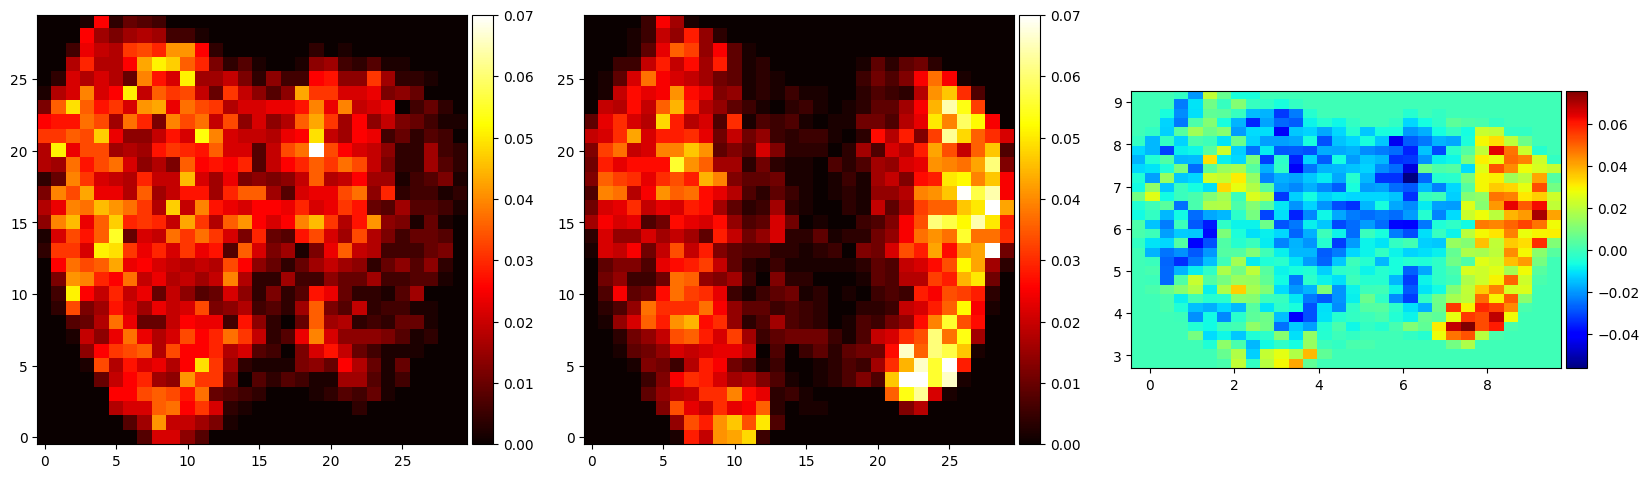

In [30]:
fig, ax = plt.subplots(figsize=[20,10], ncols=3)


# Plots heatmap of females
females = visual_df[visual_df["ypred"]==0]
Z, xedges, yedges = np.histogram2d(females["vis0"], females["vis1"], bins=30, density=True)
# Zf = Z/np.unique(Z)[-1]
Zf = Z
im = ax[0].imshow(Zf.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.07
          )
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of males
males = visual_df[visual_df["ypred"]==1]
Z, xedges, yedges = np.histogram2d(males["vis0"], males["vis1"], bins=30, density=True)
# Zm = Z/np.unique(Z)[-1]
Zm = Z
im = ax[1].imshow(Zm.T,
          origin='lower',
          cmap='hot', 
          interpolation='none',
          vmax=0.07
          )
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = plt.colorbar(im, cax=cax)

# Plots heatmap of difference
Z = Zm-Zf
im = ax[2].imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
          )

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar   = fig.colorbar(im, cax=cax)

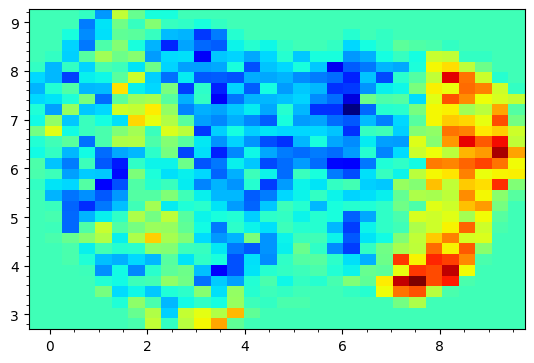

In [31]:
# Plots heatmap of difference
Z = Zm-Zf
im = plt.imshow(Z.T,
          origin='lower',
          cmap='jet', 
          interpolation='none',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
          )
plt.minorticks_on()

In [32]:
visual_df.insert(0, "cluster", 0)

In [33]:
x = visual_df["vis0"]
y = visual_df["vis1"]
conditions = [
      (x < 0.5) & (y > 6.2) & (y < 8),
      (x > 3.5) & (x < 4.5) & (y > 5) & (y < 6.2),
      (x > 5.4) & (x < 6.5) & (y > 5.8) & (y < 8.6),
      (x > 8.5) & (y > 5.6) & (y < 7.4),
      (x > 6.2) & (x < 9) & (y > 3.2) & (y < 4.4)
]
choices = [1, 2, 3, 4, 5]

visual_df["cluster"] = np.select(conditions, choices, 0)

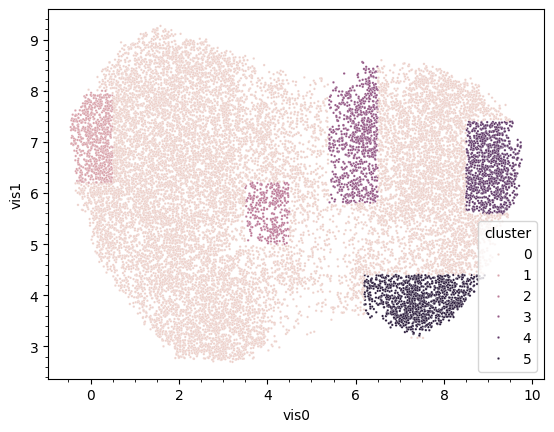

In [34]:
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue="cluster", s=3)
plt.minorticks_on()

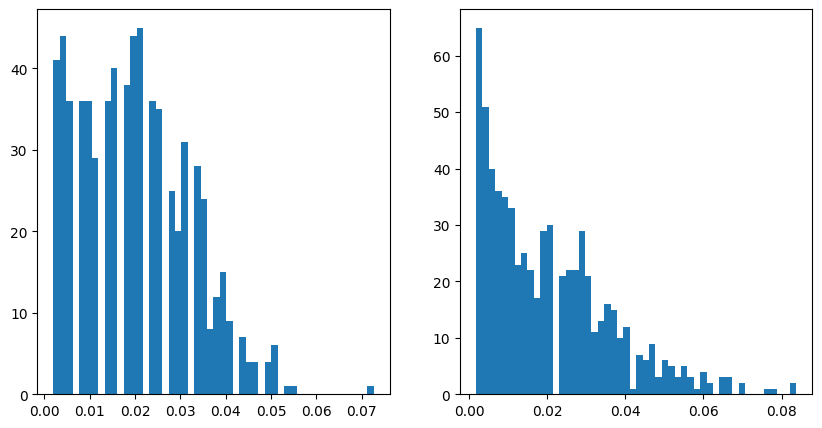

In [35]:
fig, ax = plt.subplots(figsize=[10,5], ncols=2)
p = ax[0].hist(Zf[Zf!=0].flatten(), bins=50)
p = ax[1].hist(Zm[Zm!=0].flatten(), bins=50)

<Axes: xlabel='vis0', ylabel='Count'>

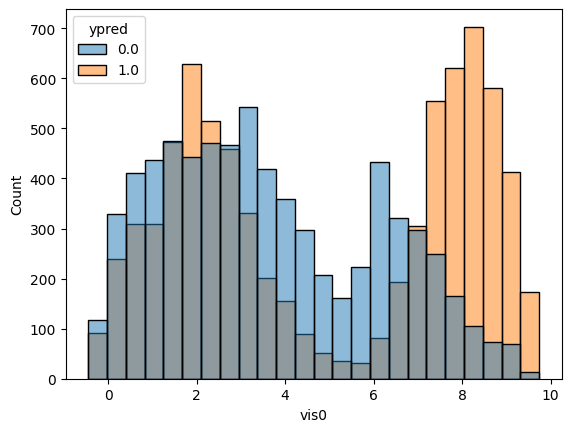

In [36]:
sns.histplot(data=visual_df, x="vis0", hue="ypred")

<Axes: xlabel='vis1', ylabel='Count'>

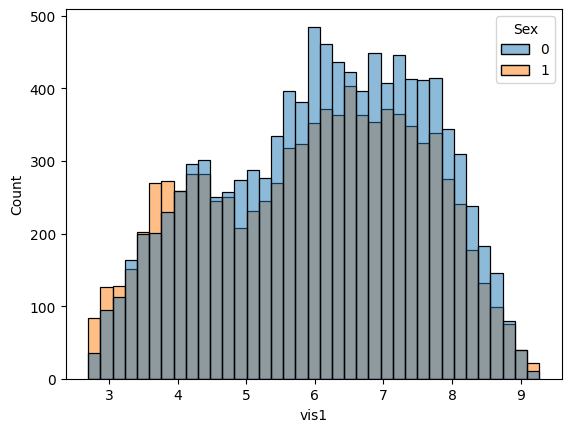

In [37]:
sns.histplot(data=visual_df, x="vis1", hue=label)

<Axes: xlabel='vis1', ylabel='Count'>

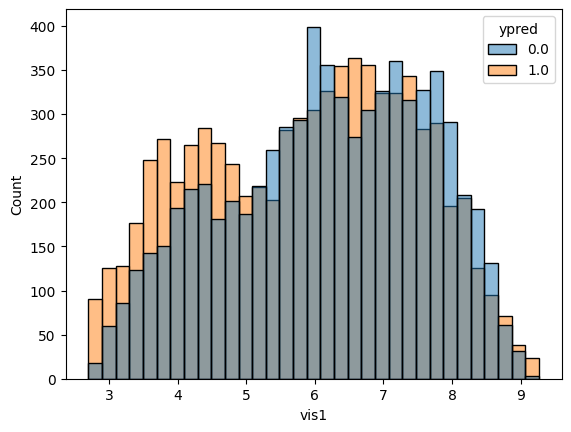

In [38]:
sns.histplot(data=visual_df, x="vis1", hue="ypred")

In [39]:
visual_df

,cluster,Sex,ypred,vis0,vis1
sub-3411469,5,1,1.0,6.745450,4.141829
sub-2290292,0,0,0.0,2.991748,3.623530
sub-4334619,0,1,NaN,1.232894,7.345156
sub-1188492,3,0,0.0,6.167345,7.029464
sub-3798925,0,0,0.0,1.252981,6.273694
...,...,...,...,...,...
sub-5405288,0,1,NaN,7.406559,6.165370
sub-5206663,0,0,NaN,1.644668,8.682719
sub-1895291,0,0,0.0,2.130881,7.906273
sub-2621329,0,1,1.0,8.900448,7.709842


<Axes: xlabel='vis0', ylabel='ypred'>

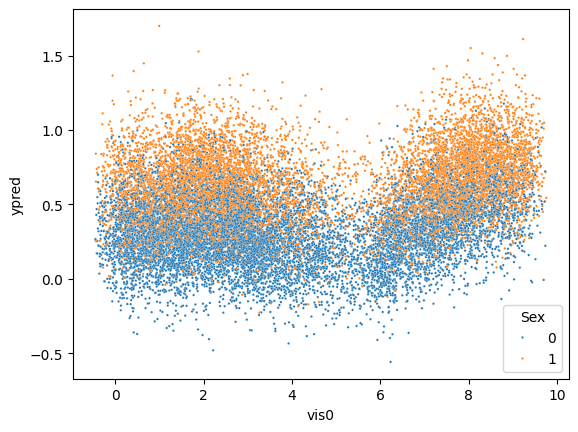

In [40]:
visual_df0 = merged0[[label, "ypred"]].copy()
visual_df0[["vis0", "vis1"]] = visual
sns.scatterplot(data=visual_df0, x="vis0", y="ypred", hue="Sex", s=3)

<Axes: xlabel='vis1', ylabel='ypred'>

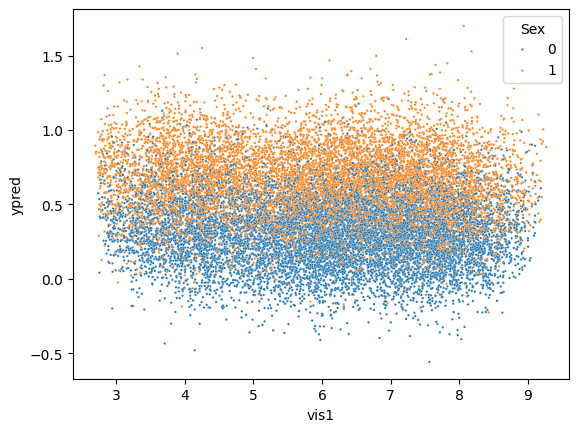

In [41]:
sns.scatterplot(data=visual_df0, x="vis1", y="ypred", hue="Sex", s=3)

In [42]:
visual_df

,cluster,Sex,ypred,vis0,vis1
sub-3411469,5,1,1.0,6.745450,4.141829
sub-2290292,0,0,0.0,2.991748,3.623530
sub-4334619,0,1,NaN,1.232894,7.345156
sub-1188492,3,0,0.0,6.167345,7.029464
sub-3798925,0,0,0.0,1.252981,6.273694
...,...,...,...,...,...
sub-5405288,0,1,NaN,7.406559,6.165370
sub-5206663,0,0,NaN,1.644668,8.682719
sub-1895291,0,0,0.0,2.130881,7.906273
sub-2621329,0,1,1.0,8.900448,7.709842


In [43]:
visual_df.to_csv(output_filename)